## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N = 4
N_filled = N // 2
E_neg1 = 0
P_neg1 = np.exp(-1j * E_neg1)
t = -0.5
g = 1e-3
m = -1
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [-0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [-0.5, 0, 3]]], ['+-', [[-1, 0, 0], [1, 1, 1], [-1, 2, 2], [1, 3, 3]]], ['+-', [[-0.0, 0, 0]]], ['+-+-', [[-0.001, 0, 0, 0, 0]]], ['+-', [[-0.002, 0, 0], [-0.002, 1, 1]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1]]], ['+-', [[-0.002, 0, 0], [-0.002, 1, 1], [-0.002, 2, 2]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 0, 0, 2, 2], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1], [-0.001, 1, 1, 2, 2], [-0.001, 2, 2, 0, 0], [-0.001, 2, 2, 1, 1], [-0.001, 2, 2, 2, 2]]], ['+-', [[-0.004, 0, 0], [-0.004, 1, 1], [-0.004, 2, 2], [-0.004, 3, 3]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 0, 0, 2, 2], [-0.001, 0, 0, 3, 3], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1], [-0.001, 1, 1, 2, 2], [-0.001, 1

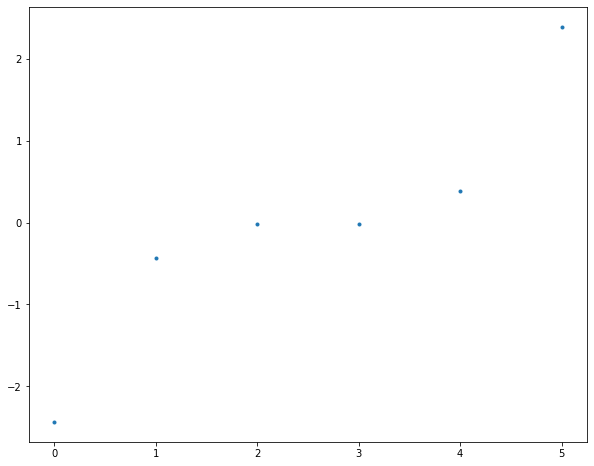

In [4]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.show()

In [5]:
# This is used later in real time dynamics, so keep a copy
H_init = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 0, 3]]], ['+-', [[-1, 0, 0], [1, 1, 1], [-1, 2, 2], [1, 3, 3]]], ['+-', [[-0.0, 0, 0]]], ['+-+-', [[-0.001, 0, 0, 0, 0]]], ['+-', [[-0.002, 0, 0], [-0.002, 1, 1]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1]]], ['+-', [[-0.002, 0, 0], [-0.002, 1, 1], [-0.002, 2, 2]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 0, 0, 2, 2], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1], [-0.001, 1, 1, 2, 2], [-0.001, 2, 2, 0, 0], [-0.001, 2, 2, 1, 1], [-0.001, 2, 2, 2, 2]]], ['+-', [[-0.004, 0, 0], [-0.004, 1, 1], [-0.004, 2, 2], [-0.004, 3, 3]]], ['+-+-', [[-0.001, 0, 0, 0, 0], [-0.001, 0, 0, 1, 1], [-0.001, 0, 0, 2, 2], [-0.001, 0, 0, 3, 3], [-0.001, 1, 1, 0, 0], [-0.001, 1, 1, 1, 1], [-0.001, 1, 1, 2, 2], [-0.001, 1, 

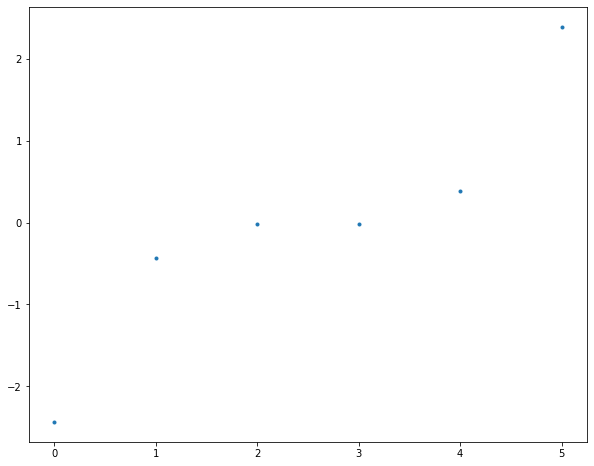

In [6]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
# E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
# for i in range(N):
#     E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
#     static_terms += [["z" * (i+1), [E_coupling]]]
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [7]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-2.43784934 -0.43525654 -0.02200054 -0.02099923  0.39240249  2.39570316]
----------------------------------------------------------------------------------------------------
Spin eigenvalues:-----------------------------------------------------------------------------------
[-2.4378495  -0.43525657 -0.02200058 -0.02099926  0.39240223  2.3957028 ]
----------------------------------------------------------------------------------------------------
Maximum difference between eigenvalues: 3.191514506006854e-07


## Real-time Dynamics

In [8]:
### Defining time-evolution hamiltonian
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
for i in range(N):
    static_terms += E_squared(i)

H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [9]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i=V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

In [10]:
T = 8#g ** (-1)
dt = T / 500

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
# file_Loschmidt = open(folder_save+'/Loschmidt_rate',"w")
# file_Loschmidt.close
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
#     file_Loschmidtfile = open(folder_save+'/Loschmidt_rate',"a")
    print(f"{times[i]}\t {Lt[i]}")#file_Loschmidtfile.write(f"{times[i]}\t {Lt[i]} \n")
    loschmidt += [Lt[i]]
#     file_Loschmidtfile.close()
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution

# T =  0.0
0.0	 5.1857760135477345e-08
0.016	 6.397792463849002e-05
0.032	 0.0002558215428825079
0.048	 0.0005757792333363463
0.064	 0.0010241794264657033
0.08	 0.0016014838141593303
0.096	 0.00230828925880239
0.112	 0.0031453302764741934
0.128	 0.004113482116369549
0.14400000000000002	 0.005213764464135041
0.16	 0.0064473458028300075
0.176	 0.007815548471778861
0.192	 0.00931985447078073
0.20800000000000002	 0.01096191206512818
0.224	 0.012743543255795037
0.24	 0.014666752189173588
0.256	 0.016733734592070306
0.272	 0.018946888330548518
0.28800000000000003	 0.021308825205928295
0.304	 0.0238223841181483
0.32	 0.026490645746177717
0.336	 0.029316948917717894
0.352	 0.032304908866646005
0.368	 0.03545843760723888
0.384	 0.03878176669003211
0.4	 0.04227947264629006
0.41600000000000004	 0.04595650547776497
0.432	 0.04981822060732247
0.448	 0.053870414776072614
0.464	 0.05811936645633943
0.48	 0.06257188145019879
0.496	 0.06723534446428216
0.512	 0.07211777759796581
0.528	 0.07722790686014

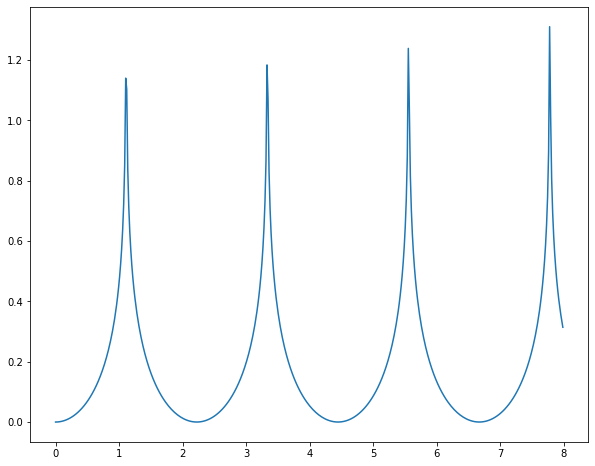

In [11]:
plt.plot(times, loschmidt)

## Joe OTOC Calculation Attempt

In [12]:
#psi_ground at t=0 correlated with psi_top at t=1

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j,dtype=dtype_cmplx)
# auxiliary array for memory efficiency

print(len(psi_i))
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
i = 1
expH.dot(psi,work_array=work_array,overwrite_v=True)

correlator = np.dot(psi_i, psi)
print("Correlator:",correlator)
# END of time evolution

6
Correlator: (0.1564755489826018+0.010268892314112724j)


## Drew Correlator calculation (Eqn. 2 of Niklas's paper)

In [13]:
c0_static = [["-",[[1.0,0]]]]
# c0_static = [["x",[[1/2,0]]], ["y",[[-1j/2,0]]]]
c0_annihilator = quantum_LinearOperator(c0_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
def cdag(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [cdag(n) for n in range(N)]
an_mat = c0_annihilator.matmat(np.eye(16, dtype=np.complex64))
print(an_mat)
# H_mat = H.aslinearoperator().matmat(np.eye(len(leftPsi), dtype=dtype_cmplx))
# print(H_mat)

[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

In [37]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
# time-evolution operator
#expmiH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
#expiH = expm_multiply_parallel(H.tocsr(),a=1j*dt,dtype=dtype_cmplx)
# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

for n in range(N): #loop over all sites
# n = 0
    for i in range(len(times)): #loop over times (for annhilator location)
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

#         print(P_Nhalf.shape)
#         print(H.tocsr().shape)
#         print(P_Nhalfminus1.shape)
#         print((np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr().dot(np.transpose(P_Nhalf)))).dot(P_Nhalfminus1)).shape)
#         print(np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr())))
        expmiH = expm_multiply_parallel((np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr().dot(np.transpose(P_Nhalf)))).dot(P_Nhalfminus1)),a=-1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H.tocsr(),a=1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True) 
#         tempLpsi = leftPsi
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
#         tempLpsi = annihilators[n].matvec(leftPsi) # e^(-iHt) . psi_n . e^(iHt) |0> = |a>
    #     an_mat = annihilators[3].matmat(np.eye(len(leftPsi), dtype=dtype_cmplx))
    #     print(np.max(an_mat))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(c0_annihilator.dot(P_Nhalf.dot(rightPsi)))
#         tempRpsi = c0_annihilator.dot(rightPsi) # |b>
#         tempRpsi = rightPsi

        correlators[n,i] = np.conj(tempLpsi).dot(tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    #     correlators[n,i] = operator.expt_value(leftPsi,rightPsi,diagonal=False,check=True)
    
correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
#print("Correlators:",correlators) #This is expectation(correlators(n)) as a function
# END of time evolution
print(correlators[0,:])

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[ 0.92703756+0.j          0.9265806 -0.02129561j  0.92521038-0.04255902j
  0.92292898-0.06375807j  0.91973984-0.08486069j  0.91564778-0.10583499j
  0.91065896-0.12664922j  0.90478091-0.14727192j  0.89802251-0.16767188j
  0.89039395-0.18781826j  0.88190673-0.20768057j  0.87257367-0.22722877j
  0.86240885-0.24643327j  0.8514276 -0.26526502j  0.83964648-0.28369552j
  0.82708328-0.30169687j  0.81375696-0.31924183j  0.7996876 -0.33630381j
  0.78489646-0.352857j    0.76940583-0.36887631j  0.75323909-0.38433747j
  0.73642064-0.39921706j  0.71897584-0.41349251j  0.70093102-0.42714218j
  0.68231341-0.44014535j  0.66315108-0.45248231j  0.64347296-0.4641343j
  0.62330874-0.47508364j  0.60268883-0.48531366j  0.58164434-0.49480882j
  0.56020703-0.50355464j  0.53840924-0.51153779j  0.51628386-0.5187461j
  0.49386426-0.52516853j  0.47118428-0.53079525j  0.44827812-0.53561762j
  0.42518036-0.5396282j   0.40192583-0.5

In [ ]:
annihilators[2]

In [57]:
correlatorfft = np.fft.fft(correlators,axis=1)

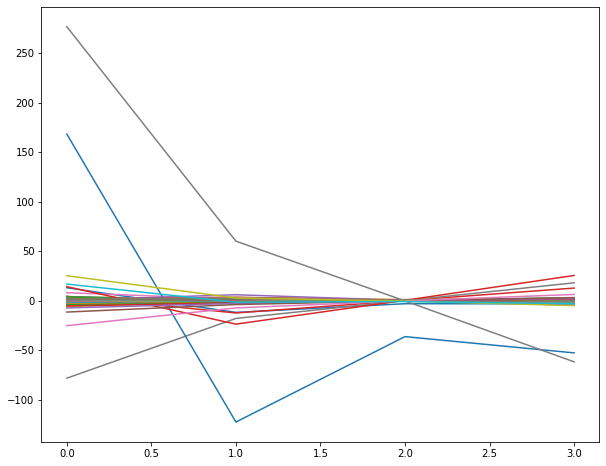

In [59]:
plt.plot(np.imag(correlatorfft[:, list(range(0, int(T/dt), 1))]))
plt.plot(np.real(correlatorfft[:, list(range(0, int(T/dt), 1))]))

Text(0.5, 0, 'lattice site n')

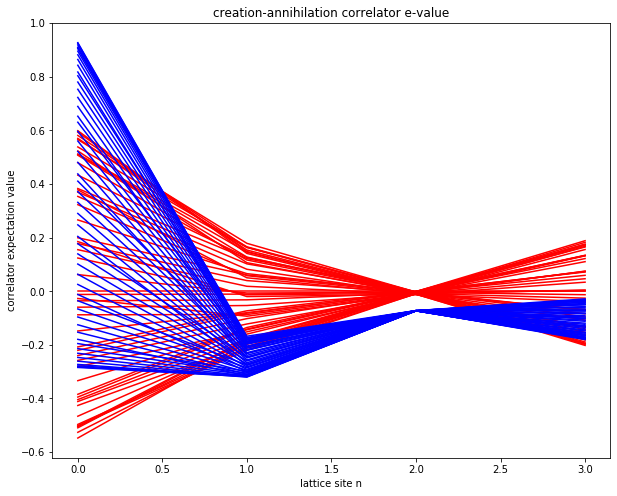

In [51]:
plt.plot(np.imag(correlators[:, list(range(0, int(T/dt), 10))]),color='red',label="Imaginary Part")
plt.plot(np.real(correlators[:, list(range(0, int(T/dt), 10))]),color='blue',label="Real Part")
plt.title("creation-annihilation correlator e-value")
plt.ylabel("correlator expectation value")
plt.xlabel("lattice site n")
# plt.figlegend()

In [ ]:
for i in correlators:
    print(abs(i))

In [ ]:
leftPsi

In [ ]:
expiH.dot(leftPsi,overwrite_v=True) 

In [ ]:
leftPsi

In [ ]:
annihilators[2].matrix_ele(1,2)

In [ ]:
annihilators[1].matmat